#### Analogy of GAN


* Discriminator-(Govt)
* generator-(ganster) -producing fake notes
govt tries to ban them
* a spy in govt gives feedback to the gangster and gangster improves creating notes
* there will be a time when the notes are produced so realistic by gangster that people think they are real notes

### Applications of GAN

* Synthetic Data Generation: Images generated by GAN have improved over the years. It can be used to generate synthetic data in case we have very less images in our dataset for training.
* Style Transfer using GAN: GAN is used to transfer style from one domain to other domain
* Super resolution image generation: GAN Can be used to generate a high-quality image from low-resolution image
* Restore Damaged image: GAN can be used to fix partially damaged images



## Import Libraries


In [1]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms

## Loading Dataset

In [11]:
def get_dl(batchsize):
  train_transforms=transforms.Compose([transforms.ToTensor()])
  train_data=MNIST(root="./train", train=True, download=True, transform=train_transforms)
  test_data=MNIST(root="./test", train=True, download=True, transform=train_transforms)

  train_loader=DataLoader(train_data, batch_size=batchsize, shuffle=True)
  test_loader=DataLoader(test_data, batch_size=batchsize, shuffle=True)

  return train_loader, test_loader


## Generator & Discriminator

In [3]:
import torch.nn as nn
import numpy as np


In [20]:
class Generator(nn.Module):
  def __init__(self, batch_size,input_dim):
    super().__init__()
    self.batch_size=batch_size
    self.input_dim=input_dim
    self.fcl=nn.Linear(input_dim, 128)
    self.LRelu=nn.LeakyReLU(0.01)
    self.fcl2=nn.Linear(128, 1*28*28)
    self.tanH=nn.Tanh()

  def forward(self, x):
    layer1=self.LRelu(self.fcl(x))
    layer2=self.tanH(self.fcl2(layer1))
    # Instead of using the fixed batch_size, use the size of the input tensor
    # to infer the actual batch size.
    out=layer2.view(x.shape[0], 1, 28, 28)
    return out

In [15]:
class Discriminator(nn.Module):
  def __init__(self, batch_size):
    super().__init__()
    self.batch_size=batch_size
    self.fcl=nn.Linear(1*28*28, 128)
    self.LRelu=nn.LeakyReLU()
    self.fcl2=nn.Linear(128, 1)
    self.sigmoid=nn.Sigmoid()

  def forward(self,x):
    # The input x likely has shape (batch_size, 1, 28, 28)
    # We need to flatten it to (batch_size, 784) before passing to the linear layer
    flat = x.view(x.size(0), -1)  # Use x.size(0) to get the actual batch size
    layer1=self.LRelu(self.fcl(flat))
    layer2=self.sigmoid(self.fcl2(layer1))
    return layer2

## Train GAN

In [24]:
def train_model(no_of_epochs, disc, gen, optimD, optimG, dataloaders, loss_fn, input_size, batch_size):
  device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
  real = 1
  fake = 0
  for epoch in range(no_of_epochs):
    for phase in ["train"]:
      for inputs, _ in dataloaders[phase]:
        inputs = inputs.to(device)

        # Get the actual batch size from the input data
        current_batch_size = inputs.shape[0]

        # Reshape the target labels using the current batch size
        real_label = torch.full((current_batch_size, 1), real, dtype=inputs.dtype, device=device)
        fake_label = torch.full((current_batch_size, 1), fake, dtype=inputs.dtype, device=device)

        optimD.zero_grad()
        output = disc(inputs)
        lossD_real = loss_fn(output, real_label)
        lossD_real.backward()

        noise = torch.randn(current_batch_size, input_size, device=device)  # Use current_batch_size for noise
        fake_img = gen(noise)
        output = disc(fake_img.detach())
        lossD_fake = loss_fn(output, fake_label)
        lossD_fake.backward()

        lossD = lossD_real + lossD_fake
        optimD.step()

        optimG.zero_grad()
        output = disc(fake_img)
        lossG = loss_fn(output, real_label)  # get feedbacks from discriminator
        lossG.backward()
        optimG.step()

In [25]:
torch.manual_seed(4)
batch_size=128
no_of_epochs=5
input_size=100
train_loader, test_loader=get_dl(batch_size)
dl={}
dl["train"]=train_loader
dl["test"]=test_loader
dataloaders=dl
gen=Generator(batch_size, input_size)
disc=Discriminator(batch_size)
loss_fn=nn.BCELoss()
optimD=torch.optim.Adam(disc.parameters(), lr=0.001, weight_decay=1e-05)
optimG=torch.optim.Adam(gen.parameters(), lr=0.001,weight_decay=1e-05)
# device=torch.device("cuda")
device=torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
disc.to(device)
gen.to(device)
train_model(no_of_epochs, disc, gen, optimD, optimG, dataloaders, loss_fn, input_size, batch_size)

##Display output

In [26]:
import matplotlib.pyplot as plt
def show_image(img):
  npimg=img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))


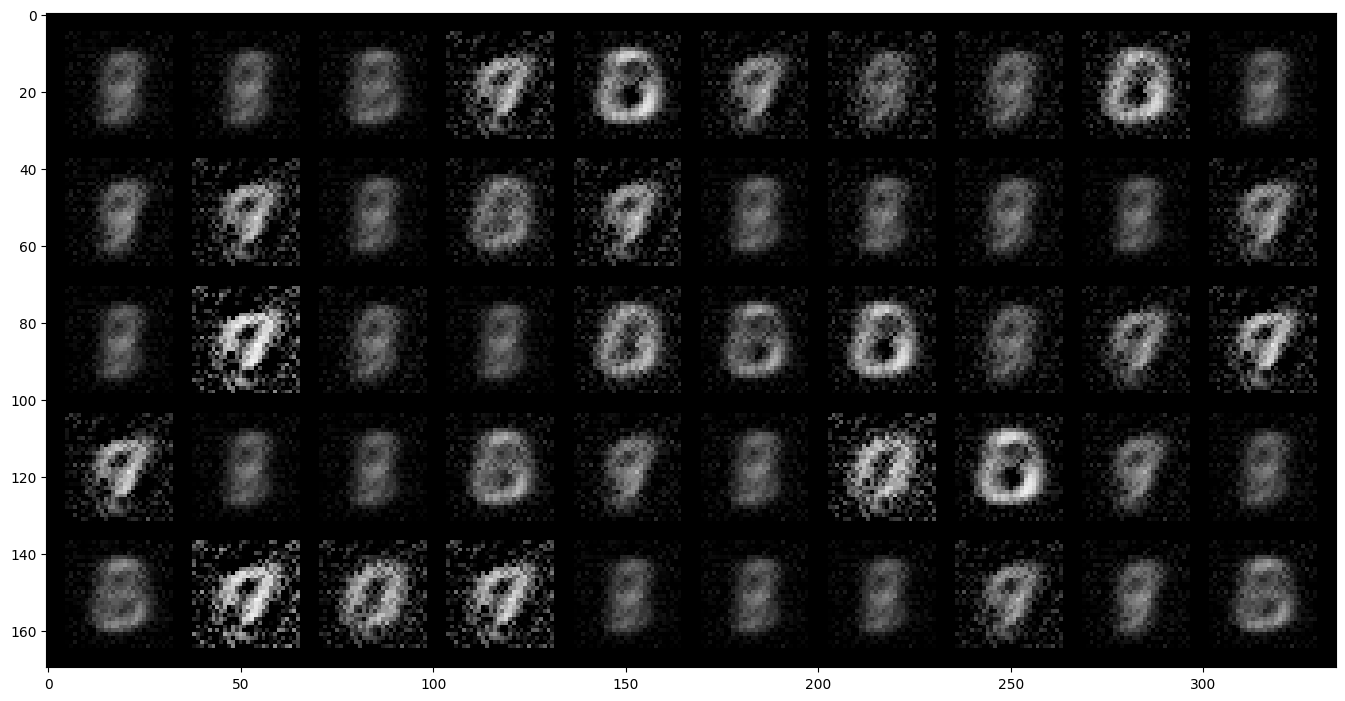

In [28]:
import torchvision
random_noise=torch.randn(128, input_size, device=device)
fake=gen(random_noise)
fake=fake.cpu()
fig,ax=plt.subplots(figsize=(20,8.5))
show_image(torchvision.utils.make_grid(fake[0:50],10,5))

### Challenges in GAN
1. Oscillating LOss
2. Model Collapse
3. Uninformative loss